# Diplomado ML & DS 
# Sesión 2: Clasificación Lineal y Evaluación del Desempeño (DEMO)

En el siguiente Demo vamos a construir un clasificador lineal para clasificar tipos de vinos. Para esto vamos a  descargarla base de datos llamada *Wine* disponible en [aquí](https://drive.google.com/open?id=0B8POkZpAJ5qQRlFzVUZnMlZVakk). Si requiere más información sobre la base datos, la puede encontrar en el siguiente link  [aquí](https://archive.ics.uci.edu/ml/datasets/wine).

El conjunto de datos contiene los ejemplos de 178 vinos. Cada uno identificado por 13 propiedades químicas:
* Alcohol
* Malic_acid
* Ash
* Alcalinity
* Magnesium
* Phenols
* Flavanoids
* Nonflavanoid
* Proanthocyanins
* Color
* Hue
* OD280/OD315
* Proline

A cada vino le fue asignada una clase, que corresponde al tipo de vino $[1, 2, 3]$

1. Cargue el conjunto de datos como un DataFrame de Pandas
2. Cargue la clase en un arreglo aparte. Eliminela del DataFrame de Pandas
3. Genere un histograma para cada propiedad del conjunto de datos
4. Use `scatter_matrix` y visualize todas las posibles combinaciones de características
    * ¿Encuentra algún par de características en el que se observan las clases bien separadas?

**Clasificación usando solo dos características y el esquema Multinomial:**
5. Entrene un modelo LogisticRegression para categorizar el tipo de vino usando `Proline` contra `Flavonoids`.
6. Entrene otro modelo LogisticRegression para categorizar el tipo de vino usando `Alcalinity` contra `Malic Acid`.
7. Imprima la región de decisión de cada clasificador.
8. Genere la matriz de confusión de cada clasificador.
9. Reporte el accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro.
    * ¿Cual modelo se desempeña mejor? ¿Por qué?

**Clasificación usando todas las características:**
10. Entrene un modelo LogisticRegression usando el esquema "*One vs All*".
11. Entrene un modelo LogisticRegression usando el esquema multinomial.
12  Genere la matriz de confusión de cada clasificador.
13  Reporte el accuracy, el error de clasificación, la precisión por clase, el recall por clase y el F1 score por clase.
  * ¿Cual modelo se desempeña mejor? ¿Por qué? ¿Cual clase es más sencilla para el clasificador?

####Importamos las librerias principales a usar en el notebook####

In [1]:
#Instalación del paquete tabulate para imprimir la matriz de confusión
!pip install tabulate

In [0]:
%matplotlib inline
import numpy as np
import pylab as pl
import seaborn as sns; sns.set()
from sklearn import preprocessing
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

#### Definimos las funciones a utilizar en el notebook####

In [0]:
def plot_data(X, y):   #Función para graficar datos (X,y)
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region2(X, pred_fun):      #Función para visualizar la superficie de decisión de nuestro algoritmo.
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 1, vmax=3)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def list_cm(cm,classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
      cm.astype(int)
      row_0 =['','Valor','Verdadero']
      row_1 =['-',classes[0],classes[1]]
      row_2 =[classes[0],cm[0,0],cm[1,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1]]
      table = zip(row_0,row_1, row_2, row_3)
      headers = ['', '', 'Valor', 'Predicho']  
      return print(tabulate(table, headers=headers, floatfmt=".0f"))
    else:
      cm.astype(int)
      row_0 =['','Valor','Verdadero','']
      row_1 =['-',np.int(classes[0]),classes[1],classes[2]]
      row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
      row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
      table = zip(row_0,row_1, row_2, row_3, row_4)
      headers = ['', '', 'Valor', 'Predicho', '']  
      return print(tabulate(table, headers=headers, floatfmt=".0f")) 

###1. Cargamos el conjunto de datos como un DataFrame de Pandas###

In [3]:
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 1.9MB/s 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Autenticación y creación del cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
file_list = drive.ListFile({'q': "'1mTJ1mrVKbOlluPX7flIQy9l4E4G95EIk' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  #https://drive.google.com/drive/folders/1mTJ1mrVKbOlluPX7flIQy9l4E4G95EIk?usp=sharing

title: wine.data.txt, id: 1-6F-qmqT1OXvWNrkXUGXuNvmiW1cvw7K


In [0]:
train_downloaded = drive.CreateFile({'id': '1-6F-qmqT1OXvWNrkXUGXuNvmiW1cvw7K'})
train_downloaded.GetContentFile('wine.data.txt')

In [7]:
import pandas as pd
wine_df = pd.read_csv('wine.data.txt')
wine_df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [12]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Class               178 non-null int64
Alcohol             178 non-null float64
 Malic_acid         178 non-null float64
 Ash                178 non-null float64
 Alcalinity         178 non-null float64
 Magnesium          178 non-null int64
 Phenols            178 non-null float64
 Flavanoids         178 non-null float64
 Nonflavanoid       178 non-null float64
 Proanthocyanins    178 non-null float64
Color               178 non-null float64
 Hue                178 non-null float64
 OD280/OD315        178 non-null float64
 Proline            178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


###2. Cargamos la clase en un arreglo aparte y la eliminamos del DataFrame de Pandas###

In [8]:
classes = wine_df['Class'].unique()
print(classes)
wine_no_classes = wine_df.drop(columns='Class').copy()
wine_no_classes.head()

[1 2 3]


,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


###3. Generamos un histograma para cada propiedad del conjunto de datos###

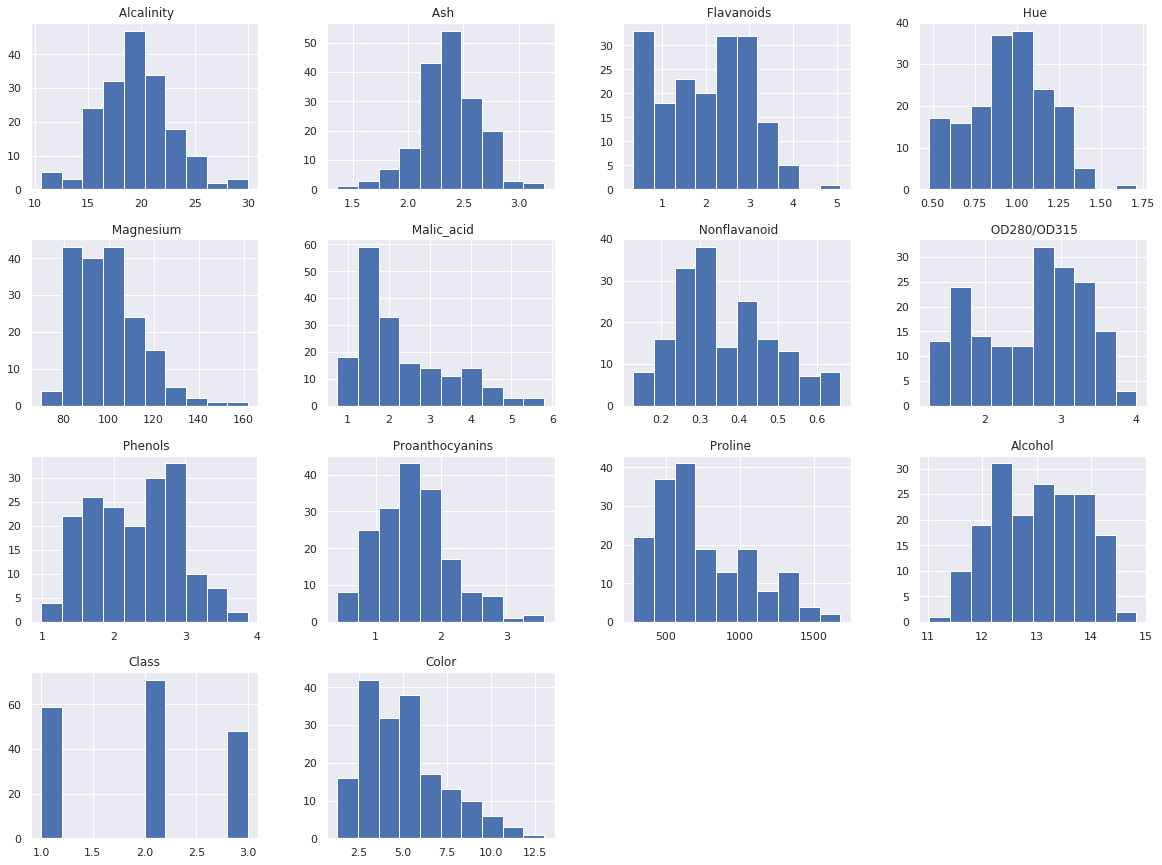

In [9]:
a=wine_df.hist(figsize=(20, 15))

###4. Usamos `scatter_matrix` y visualizamos todas las posibles combinaciones de características###
    * ¿Se encuentra algún par de características en el que se observan las clases bien separadas?

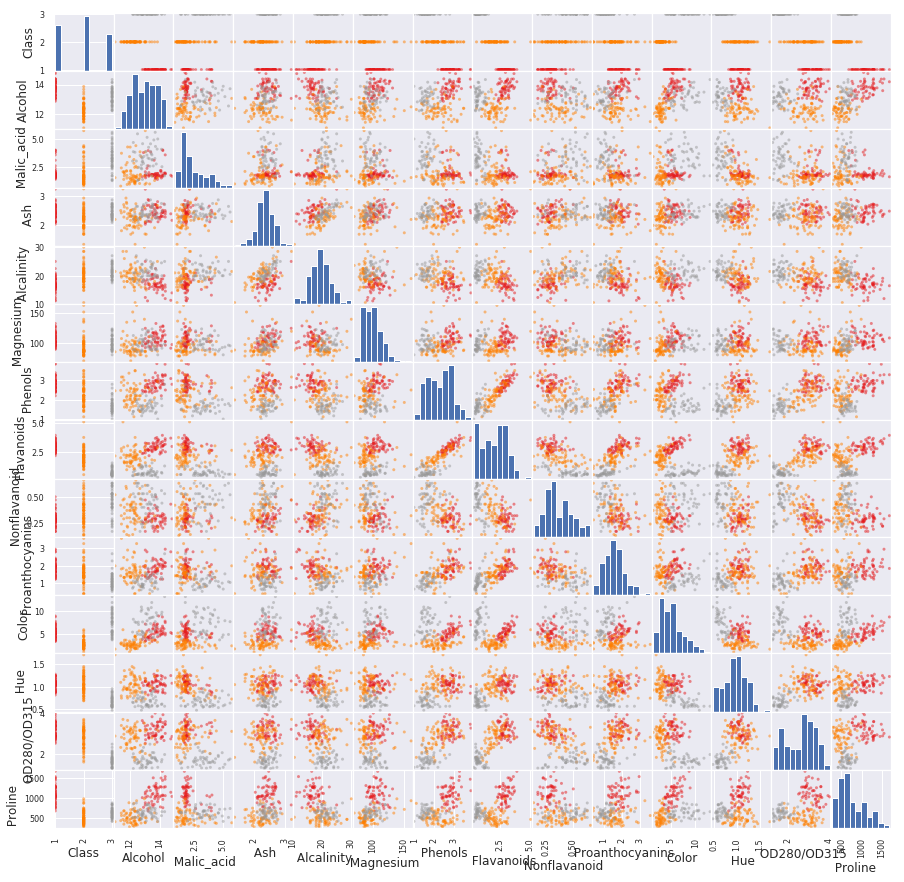

In [10]:
d = pd.plotting.scatter_matrix(wine_df, c=wine_df.Class, cmap='Set1', figsize=(15, 15))

# Clasificación usando solo dos características y el esquema Multinomial:

###5. Entrenamos un modelo LogisticRegression para categorizar el tipo de vino usando `Proline` contra `Flavonoids`.###

In [11]:
from sklearn.linear_model import LogisticRegression
y = wine_df[['Class']].as_matrix()[:,0]
y.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(178,)

In [13]:
X_1 = wine_df[[' Proline    ', ' Flavanoids']].as_matrix()
print(X_1.shape)
classifier_1 = LogisticRegression(multi_class='multinomial', solver='lbfgs');
classifier_1.fit(X_1, y)

(178, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###6. Entrenamos otro modelo LogisticRegression para categorizar el tipo de vino usando `Alcalinity` contra `Malic Acid`.###

In [14]:
X_2 = wine_df[[' Alcalinity', ' Malic_acid']].as_matrix()
classifier_2 = LogisticRegression(multi_class='multinomial', solver='lbfgs');
classifier_2.fit(X_2,  y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###7. Imprimimos la región de decisión de cada clasificador.###

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


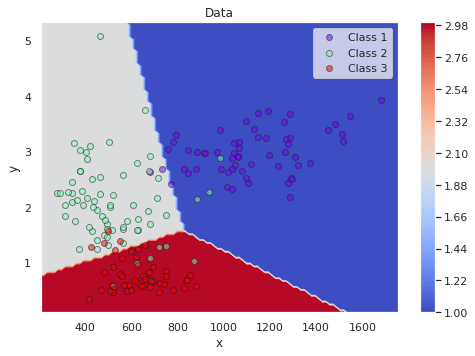

In [17]:
pl.figure(figsize = (8,16/3))    
plot_decision_region2(X_1, gen_pred_fun(classifier_1))
plot_data(X_1, y)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


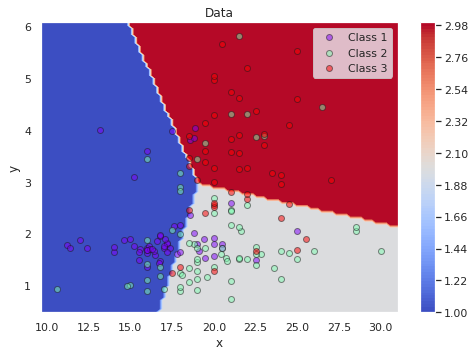

In [18]:
pl.figure(figsize = (8,16/3))    
plot_decision_region2(X_2, gen_pred_fun(classifier_2))
plot_data(X_2, y)

###8. Generamos la matriz de confusión de cada clasificador.###

In [0]:
prediction_1 = classifier_1.predict(X_1)
prediction_2 = classifier_2.predict(X_2)

In [20]:
cnf_matrix_1 = confusion_matrix(y, prediction_1)
list_cm(cnf_matrix_1, classes=classes)

                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        56           3   0
Verdadero  2         3          62   6
           3         0           5  43


In [21]:
cnf_matrix_2 = confusion_matrix(y, prediction_2)
list_cm(cnf_matrix_2, classes=classes)

                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        40          16   3
Verdadero  2        16          47   8
           3         3          15  30


###9. Reportamos el accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro.###
    * ¿Cual modelo se desempeña mejor? ¿Por qué?

In [22]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('Accurracy Proline & Flavanoids: {}'.format(classifier_1.score(X_1, y)))
print('Error de clasificación Proline & Flavanoids: {}'.format(1 - classifier_1.score(X_1, y)))
print('Precisión macro Proline & Flavanoids: {}'.format(precision_score(y, prediction_1, average='macro')))
print('Recall macro Proline & Flavanoids: {}'.format(recall_score(y, prediction_1, average='macro')))
print('F1 macro Proline & Flavanoids: {}'.format(f1_score(y, prediction_1, average='macro')))

Accurracy Proline & Flavanoids: 0.9044943820224719
Error de clasificación Proline & Flavanoids: 0.0955056179775281
Precisión macro Proline & Flavanoids: 0.9041392828317768
Recall macro Proline & Flavanoids: 0.9060751041086443
F1 macro Proline & Flavanoids: 0.9050610348768955


In [23]:
print('Accurracy Alcalinity & Malic_acid: {}'.format(classifier_2.score(X_2, y)))
print('Error de clasificación Alcalinity & Malic_acid: {}'.format(1 - classifier_2.score(X_2, y)))
print('Precisión macro Alcalinity & Malic_acid: {}'.format(precision_score(y, prediction_2, average='macro')))
print('Recall macro Alcalinity & Malic_acid: {}'.format(recall_score(y, prediction_2, average='macro')))
print('F1 macro Alcalinity & Malic_acid: {}'.format(f1_score(y, prediction_2, average='macro')))

Accurracy Alcalinity & Malic_acid: 0.6573033707865169
Error de clasificación Alcalinity & Malic_acid: 0.3426966292134831
Precisión macro Alcalinity & Malic_acid: 0.6707458404440629
Recall macro Alcalinity & Malic_acid: 0.6549793108936103
F1 macro Alcalinity & Malic_acid: 0.6609986294290593


In [24]:
X_all = wine_no_classes.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


#Clasificación usando todas las características

###10. Entrenamos un modelo LogisticRegression usando el esquema "*One vs All*".###

In [25]:
classifier_ovr = LogisticRegression(multi_class='ovr')
classifier_ovr.fit(X_all, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

###11. Entrenamos un modelo LogisticRegression usando el esquema multinomial.###

In [26]:
classifier_multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs')
classifier_multinomial.fit(X_all, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
prediction_ovr = classifier_ovr.predict(X_all)
prediction_multinomial = classifier_multinomial.predict(X_all)

###12  Generamos la matriz de confusión de cada clasificador.###

In [0]:
prediction_3 = classifier_ovr.predict(X_all)
prediction_4 = classifier_multinomial.predict(X_all)

In [29]:

cnf_matrix_3 = confusion_matrix(y, prediction_3)
list_cm(cnf_matrix_3, classes=classes)


                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        57           2   0
Verdadero  2         0          69   2
           3         0           1  47


In [30]:

cnf_matrix_4 = confusion_matrix(y, prediction_4)
list_cm(cnf_matrix_4, classes=classes)

                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        56           3   0
Verdadero  2         0          69   2
           3         0           1  47


###13  Reportamos el accuracy, el error de clasificación, la precisión por clase, el recall por clase y el F1 score por clase.###
  * ¿Cual modelo se desempeña mejor? ¿Por qué? ¿Cual clase es más sencilla para el clasificador?

In [31]:
print('Accuracy OVR: {}'.format(classifier_ovr.score(X_all, y)))
print('Error de clasificación OVR: {}'.format(1 - classifier_ovr.score(X_all, y)))
print('Precisión por clase OVR: {}'.format(precision_score(y, prediction_ovr, average=None)))
print('Recall por clase OVR: {}'.format(recall_score(y, prediction_ovr, average=None)))
print('F1 por clase OVR: {}'.format(f1_score(y, prediction_ovr, average=None)))

Accuracy OVR: 0.9719101123595506
Error de clasificación OVR: 0.028089887640449396
Precisión por clase OVR: [1.         0.95833333 0.95918367]
Recall por clase OVR: [0.96610169 0.97183099 0.97916667]
F1 por clase OVR: [0.98275862 0.96503497 0.96907216]


In [32]:
print('Accuracy Multinomial: {}'.format(classifier_multinomial.score(X_all, y)))
print('Error de clasificación Multinomial: {}'.format(1 - classifier_multinomial.score(X_all, y)))
print('Precisión por clase Multinomial: {}'.format(precision_score(y, prediction_multinomial, average=None)))
print('Recall por clase Multinomial: {}'.format(recall_score(y, prediction_multinomial, average=None)))
print('F1 por clase Multinomial: {}'.format(f1_score(y, prediction_multinomial, average=None)))

Accuracy Multinomial: 0.9662921348314607
Error de clasificación Multinomial: 0.0337078651685393
Precisión por clase Multinomial: [1.         0.94520548 0.95918367]
Recall por clase Multinomial: [0.94915254 0.97183099 0.97916667]
F1 por clase Multinomial: [0.97391304 0.95833333 0.96907216]


In [0]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(y, prediction_ovr))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98        59
           2       0.96      0.97      0.97        71
           3       0.96      0.98      0.97        48

    accuracy                           0.97       178
   macro avg       0.97      0.97      0.97       178
weighted avg       0.97      0.97      0.97       178

